# To do:

- Use the Atlantic Causal Inference Conference Simulations
- data starvation experiment

In [2]:
library(Matching)
library(plyr)
library(tidyverse)
library(stringr)
library(magrittr)
library(caret)
library(itecv)
# detach("package:plyr", unload=TRUE)

In [6]:
methods = list("ranger",
               "enet")
tune_grids = list(expand.grid(mtry = c(3,5),
                              splitrule="variance",
                              min.node.size=5),
                  expand.grid(fraction=0.5, 
                              lambda=exp(seq(-5,2,0.5))))
models = list(methods, tune_grids) %>%
    pmap(~list(method=.x, tune_grid=.y))

DGP = powers_DGPs()[[3]]
training_percent = 0.5
n_folds = 5
rep = 1
n = 100

data_stuff = setup_data(DGP, n, training_percent, n_folds)
estimate_stuff = data_stuff %$% get_estimates(data, models, cv_index, test_index)
# estimate_stuff = data_stuff %$% get_estimates(data, list(models[[2]]), cv_index, test_index)
error_stuff = estimate_stuff %$% get_errors(cv_estimates, test_estimates, data_stuff$aux_data)

## plot

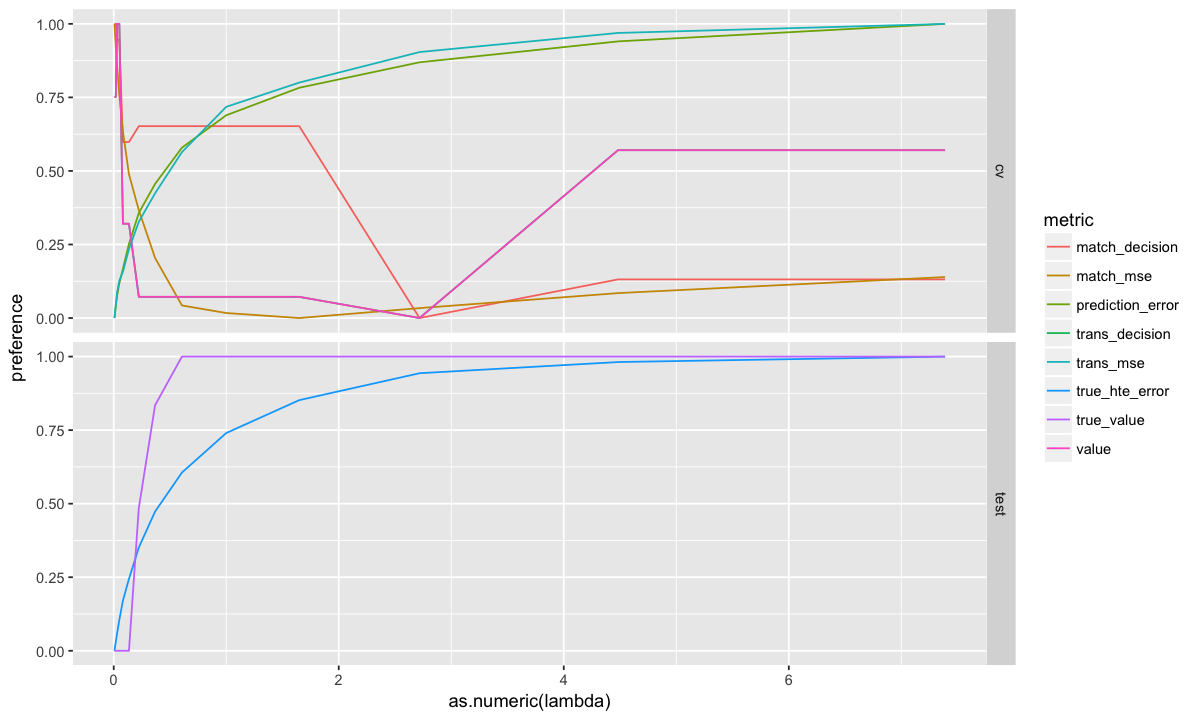

In [14]:
options(repr.plot.width=10, repr.plot.height=6)

cv_plot = error_stuff$cv_error %>%
    filter(str_detect(model,"^enet")) %>%
    separate(model, c("method", names(models[[2]]$tune_grid)), sep="~") %>%
    rename(metric=selection_method) %>%
    group_by(metric) %>%
    mutate(preference = (error - min(error, na.rm=T))/(max(error, na.rm=T)-min(error, na.rm=T))) %>%
    mutate(evaluation = "cv") 

# ggplot(aes(x=as.numeric(nrounds), y=preference)) + 
#     geom_line(aes(color=metric)) 

test_plot = error_stuff$test_error %>% 
    filter(str_detect(model,"^enet")) %>%
    separate(model, c("method", names(models[[2]]$tune_grid)), sep="~") %>%
    gather(metric, error, true_hte_error, true_value) %>%
    group_by(metric) %>%
    mutate(preference = (error - min(error))/(max(error)-min(error))) %>%
    mutate(evaluation = "test")

# # ggplot(aes(x=as.numeric(nrounds), y=preference)) + 
# #     geom_line(aes(color=metric), size=3) 

cv_plot %>% bind_rows(test_plot) %>%
ggplot(aes(x=as.numeric(lambda), y=preference)) + 
    geom_line(aes(color=metric)) + 
    facet_grid(evaluation~.)

In [15]:
error_stuff$true_selection_error %>% arrange(-true_hte_error) %>% data.frame

,model,selection_method,true_hte_error,true_value
1,enet~0.5~2.71828182845905,match_decision,5.899724,-1.529891
2,enet~0.5~2.71828182845905,trans_decision,5.899724,-1.529891
3,enet~0.5~2.71828182845905,value,5.899724,-1.529891
4,enet~0.5~1.64872127070013,match_mse,5.624374,-1.529891
5,enet~0.5~0.00673794699908547,prediction_error,3.062431,-1.639423
6,enet~0.5~0.00673794699908547,trans_mse,3.062431,-1.639423


In [9]:
loop_test = function(setup) {
    DGP = setup$DGP
    n = setup$n
    n_folds = setup$n_folds
    training_percent = setup$training_percent
    rep = setup$rep
    models = setup$models
    
    datas = setup_data(DGP$DGP, n, training_percent, n_folds)
    estimates = datas %$% get_estimates(data, models, cv_index, test_index) 
    errors =  estimates %$% get_errors(cv_estimates, test_estimates, datas$aux_data) 
    true_selection_error = errors$true_selection_error %>%
        mutate(DGP=DGP$name, n_folds=n_folds, training_percent=training_percent, rep=rep)
    
    return(true_selection_error)
}

In [10]:
methods = list("ranger",
               "enet")
tune_grids = list(expand.grid(mtry = c(3,5),
                              splitrule="variance",
                              min.node.size=5),
                  expand.grid(fraction=c(0.1,0.5,0.9) 
                              lambda=exp(seq(-5,2,0.2))))
models = list(methods, tune_grids) %>%
    pmap(~list(method=.x, tune_grid=.y))

simulation_params = list(DGP=powers_DGPs()[1:2] %>% 
                             imap(~list(name=.y, DGP=.x)),
                         n = 300,
                         n_folds=3,
                         training_percent=0.5,
                         rep = 1:2) %>%
cross
setups = simulation_params %>%
    map(~c(.,"models"=list(models)))

In [11]:
derp = setups[[1]] %>% loop_test %>% data.frame

In [12]:
results = setups %>% 
    map(~loop_test(.)) %>%
    bind_rows

In [14]:
results %>% data.frame

,model,selection_method,true_hte_error,true_value,DGP,n_folds,training_percent,rep
1,ranger~5~variance~1,match_decision,0.5846871,-0.1318893,scenario_1,3,0.5,1
2,ranger~3~variance~1,match_mse,0.4812848,-0.1318893,scenario_1,3,0.5,1
3,enet~0.5~7.38905609893065,prediction_error,0.6790113,-0.1318893,scenario_1,3,0.5,1
4,enet~0.5~7.38905609893065,trans_decision,0.6790113,-0.1318893,scenario_1,3,0.5,1
5,ranger~3~variance~1,trans_mse,0.4812848,-0.1318893,scenario_1,3,0.5,1
6,enet~0.5~7.38905609893065,value,0.6790113,-0.1318893,scenario_1,3,0.5,1
7,ranger~3~variance~1,match_decision,4.97355,-0.5302864,scenario_2,3,0.5,1
8,ranger~3~variance~1,match_mse,4.97355,-0.5302864,scenario_2,3,0.5,1
9,enet~0.5~7.38905609893065,prediction_error,5.587761,-0.4395167,scenario_2,3,0.5,1
10,ranger~3~variance~1,trans_decision,4.97355,-0.5302864,scenario_2,3,0.5,1


In [55]:
processed_results = results %>%
    group_by(DGP, rep) %>% 
    mutate(rel_value = true_value/max(true_value, rm.na=T),
#        rel_value_opt = true_deficiency/optimal_deficiency,
       rel_increased_error = true_hte_error/min(true_hte_error, rm.na=T))

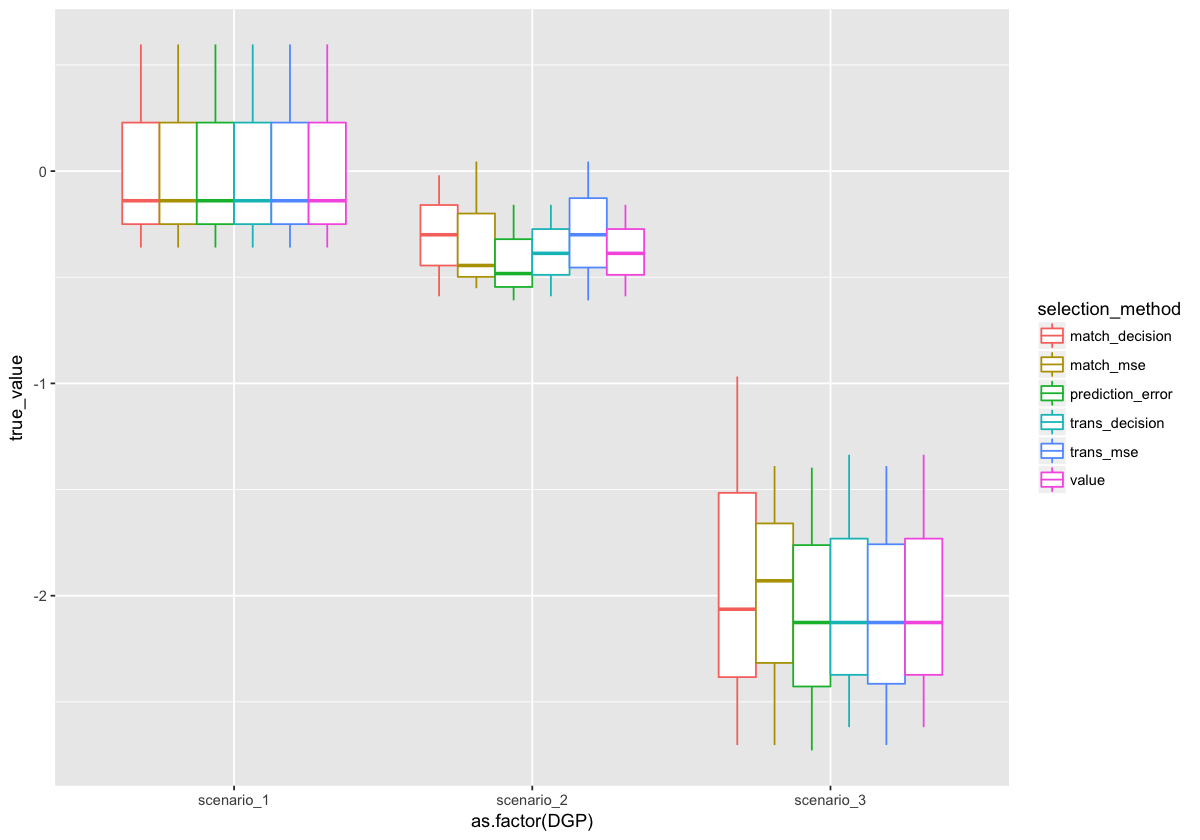

In [57]:
options(repr.plot.width=10, repr.plot.height=7)
processed_results %>%
ggplot(aes(x=as.factor(DGP), y=true_value, color=selection_method)) +
    geom_boxplot()

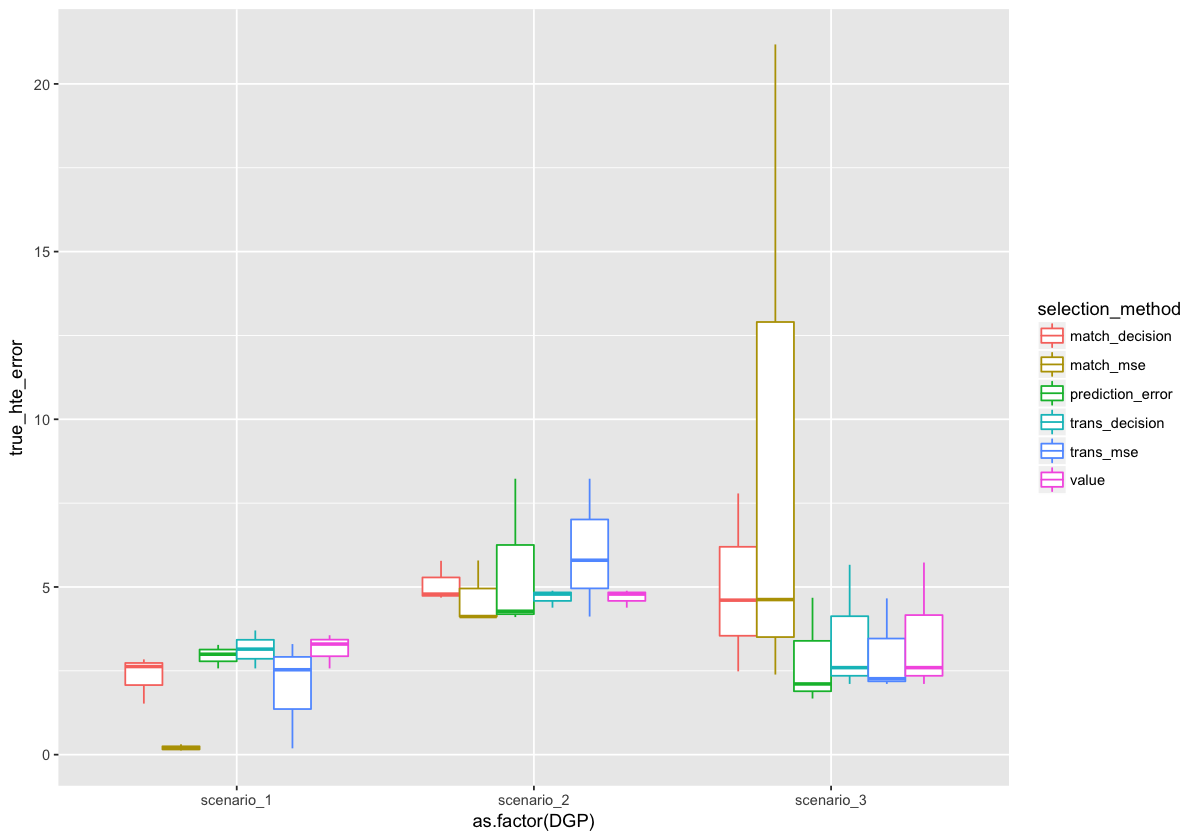

In [58]:
options(repr.plot.width=10, repr.plot.height=7)
results %>%
ggplot(aes(x=as.factor(DGP), y=true_hte_error, color=selection_method)) +
    geom_boxplot()